# Project Title
### Data Engineering Capstone Project

#### Project Summary
The objective of this project is to create an ETL pipeline which serves a start-model schema.
A use case for this data model would be to find out migration patterns to the USA.


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [3]:
# Do all imports and installs here
import pathlib
import logging
import re
from datetime import datetime

import pandas as pd
import numpy as np

In [15]:
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import year, month, dayofmonth, weekofyear, date_format
from pyspark.sql.functions import sum as sp_sum
import pyspark.sql.functions as f
from pyspark.sql import SparkSession


from pyspark.sql.types import \
                            StringType as Str, \
                            IntegerType as Int, \
                            StructType as R, \
                            StructField as Fld, \
                            DoubleType as Dbl

In [3]:
logger = logging.getLogger() # __file__
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [16]:
spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

# Step 1: Scope the Project and Gather Data

---
## Project Scope
##### *Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>*

The goal of this project is to provide data consummers access to a dimension model using a Star-model schema. 
To do that, the following steps are taken:

1. Data will be gathered from 3 different sources. Those raw datasets will be kept on premise.

2. All the data will be loaded into dataframes, where the data will be first cleaned and validated using Spark and pandas. Validated datasets will be stored in a ``stagging`` area.

3. Finally, stagging dataframes will be transformed and fact and dimension tables will be created and stored under a ``tables`` location.

NOTE:

Fact and dimension tables will be created to form a star model schema (easier for queries and analytics). All these tables will be written to csv files. Fact table will be partitioned by year and month.




## Describe and Gather Data 
##### *Describe the data sets you're using. Where did it come from? What type of information is included?*


Three data sources are used in this project:

**1. I94 Immigration Data:**

- This data comes from the US National Tourism and Trade Office (https://www.trade.gov/national-travel-and-tourism-office).
- This dataset contains information about immigration records such as the month and year, immigrants' gender, country of residence, birthday and occupation while in the US, port of arrival and US State, Mode of Transportation (Air, Sea, Land, ...), among others.
- For this project the data is in a folder located at ``../../data/18-83510-I94-Data-2016``. There is a SAS file (``sas7bdat`` format) for each month of the year.
- This dataset will serve as a basis to the fact table in our dimension model.

**2. U.S City Demographic Data:**
- Simple table with demographic statistics of US cities.
- This dataset includes information about the population of US cities such as race, household size, median age and population size.
- Source: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/ (OpenSoft)
- This dataset will serve as a dimension to our dimension model.

**3. Airport Code Table:**
- This is a simple table of airport codes and corresponding cities.
- Source: https://datahub.io/core/airport-codes#data
- The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia).
- This dataset will serve as a dimension to our dimension model.

### PATHS
---

In [4]:
# Some required paths

stagging_output_dir = './datasets/stagging'
table_output_dir = './datasets/tables'

# RAW
IMM_RAW_DIR = '../../data/18-83510-I94-Data-2016/'
SAS_LABELS_RAW_FILE = '../../data/I94_SAS_Labels_Descriptions.SAS'
AIRPORTS_RAW_FILE = './airport-codes_csv.csv'
DEMOGRAPHICS_RAW_FILE = './us-cities-demographics.csv'

# STAGGING
IMM_STAG_DIR = stagging_output_dir + '/immigration'
COUNTRIES_STAG_FILE = stagging_output_dir + '/df_countries.csv'
PORTS_STAG_FILE = stagging_output_dir + '/df_ports.csv'
MODES_TRANSP_STAG_FILE = stagging_output_dir + '/df_modes_transport.csv'
STATES_STAG_FILE = stagging_output_dir + '/df_states.csv'
AIRPORTS_STAG_FILE = stagging_output_dir + '/df_airports.csv'
DEMOGRAPHICS_STAG_FILE = stagging_output_dir + '/df_city_demographics.csv'

# TABLES
IMM_TAB_DIR = table_output_dir + '/immigration'
CALENDAR_TAB_DIR = table_output_dir + '/calendar'
PORTS_TAB_DIR = table_output_dir + '/ports'
COUNTRY_TAB_DIR = table_output_dir + '/country'
US_STATES_TAB_DIR = table_output_dir + '/us_states'

## Step 2: Explore and Assess the Data
---
#### Explore the Data 
*Identify data quality issues, like missing values, duplicate data, etc.*

Exploratory Data anlysis has been done for all datasets using pandas (see ``EDA.ipynb``).
Some columns showed a lot of missing values. To validate and clean all dataframes, logic has been developed based on different criteria, such as missing values, duplicated data and so on. 
All this logic is encapsulated into `CleanPandasDf` object (see below).

#### Cleaning Steps
*Document steps necessary to clean the data*

The following steps are performed when cleaning datasets with pandas:
- Empty rows are dropped.
- Empty columns are dropped.
- Duplicated rows are dropped (last record is kept).
- All columns where > 10% of data is missing are dropped.
- White space is stripped from all cells.
- All cells are transformed into lower case.
- Specific columns are expanded into more than one column.

In [5]:
class CleanPandasDf(pd.DataFrame):

    @staticmethod
    def drop_empty_rows(df):
        logger.info('Droping all empty rows ...')
        df.dropna(axis=0, how='all', inplace=True) # drop rows with all missing values

    @staticmethod
    def drop_empty_cols(df):
        logger.info('Droping all empty cols ...')
        df.dropna(axis=1, how='all', inplace=True)

    @staticmethod
    def drop_duplicated_rows(df, keep='last'):
        logger.info(f'Droping duplicated rows and keeping {keep} record...')
        df.drop_duplicates(keep=keep, inplace=True)

    @staticmethod
    def drop_col_if_missing_data_more_than_perc(df, col_name, perc=10):
        """ Drops column ``col_name`` if percentage of NAN values is more than a threshold ``perc``.

        Parameters:
            col_name (str) : column name to be inspected.
            perc (float | int) : value such that percetange NANs above that value, column is dropped
        """
        if col_name not in df.columns:
            raise ValueError(f'col_name = {col_name} does not exist in dataframe ..')

        number_rows = len(df.index)
        number_col_nan = df[col_name].isna().sum()
        number_col_nan_perc = 100 * number_col_nan / number_rows
        logger.debug(f'% NAN in column "{col_name}" = {number_col_nan_perc:.1f} %...')

        if number_col_nan_perc > perc:
            logger.info(f'Dropping column "{col_name}" because it contains {number_col_nan_perc:.1f} % NAN values (> {perc} %)')
            df.drop(col_name, axis=1, inplace=True)

    @staticmethod
    def drop_all_cols_if_missing_data_is_more_than_perc(df, exclude_cols = tuple(), perc=10):
        """Drop all columns in dataframe if percentage of NANs is more than ``perc``.
        NOTE: All columns in exclude_cols are ignored.

        Parameters:
            exclude_cols (tuple | list) : tuple/list of columns to be excluded
            perc (float | int) : value such that percetange NANs above that value, columns are dropped
        """
        logger.info(f'Droping all cols where number NAN is above {perc} % ...')
        for col in df.columns:
            if col not in exclude_cols:
                CleanPandasDf.drop_col_if_missing_data_more_than_perc(df, col_name=col, perc=perc)

    @staticmethod
    def split_column_based_on_separator(df, col_name,  list_new_cols, separator=',', force_types=False, new_cols_types=tuple()):
        if force_types:
            if not new_cols_types:
                raise ValueError('Please provide "new_cols_types" when using force_types=True')
            if len(new_cols_types) != len(list_new_cols):
                raise ValueError('Size of "new_cols_types" array must be the same as size of "list_new_cols"')
        df[list_new_cols] = df[col_name].str.split(separator, expand=True)
        if force_types:
            df[list_new_cols].astype(*new_cols_types)

        return df

    @staticmethod
    def strip_white_text_from_all_cells(df):
       df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
       df.replace(r'^\s*$', np.nan, regex=True, inplace=True) # replace all empty space with NAN

    @staticmethod
    def lower_case_all_cells(df):
        df = df.apply(lambda x: x.astype(str).str.lower())
        df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [6]:
df_airports = pd.read_csv(AIRPORTS_RAW_FILE)
print('Dimensions before cleaning: ', df_airports.shape)
CleanPandasDf.strip_white_text_from_all_cells(df_airports)
CleanPandasDf.lower_case_all_cells(df_airports)
CleanPandasDf.drop_all_cols_if_missing_data_is_more_than_perc(df_airports)
CleanPandasDf.drop_duplicated_rows(df_airports)
CleanPandasDf.drop_empty_cols(df_airports)
CleanPandasDf.drop_empty_rows(df_airports)
df_airports = CleanPandasDf.split_column_based_on_separator(df_airports, 'coordinates', ['lat', 'long'], separator=',', force_types=True, new_cols_types=(float, float))
print('Dimensions after cleaning: ', df_airports.shape)


Dimensions before cleaning:  (55075, 12)


Droping all cols where number NAN is above 10 % ...
Dropping column "elevation_ft" because it contains 12.7 % NAN values (> 10 %)
Dropping column "continent" because it contains 50.3 % NAN values (> 10 %)
Dropping column "municipality" because it contains 10.3 % NAN values (> 10 %)
Dropping column "gps_code" because it contains 25.5 % NAN values (> 10 %)
Dropping column "iata_code" because it contains 83.3 % NAN values (> 10 %)
Dropping column "local_code" because it contains 47.9 % NAN values (> 10 %)
Droping duplicated rows and keeping last record...
Droping all empty cols ...
Droping all empty rows ...


Dimensions after cleaning:  (55075, 8)


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
###### *Map out the conceptual data model and explain why you chose that model*

The ``immigration`` fact table is the heart of the data model. The data used in this table comes from all the immigration SAS files. This table has as foreign key a link to the other 4 dimension tables.
The data dictionary of the immigration dataset contains detailed information on the data that makes up the fact table.

The ``us-states`` table contains data from the immigration and us demographics datasets (after being grouped by state). This dimension allows analysts to get insights into migration patterns into the US based on demographic statistics. For instance, we can understand whether states with more population attract more vistors. 

The ``calendar`` allows the analysts to narrow its studies on a particular month, year, ..., as well as to extract additional date information concerning the arrival date of migrants.

The ``ports`` table allows to draw insights into migration patterns into the US and specific ports (& airports). This table is made of both immigration and airport datasets. Linking this dimension with the fact table, one can understand which airports/ports have more people arriving into the US, as well in which states are these ports located.

Finaly, the ``country`` table links an immigrant's country of residence (i94res) and birth (i94bir) code in the fact table to a country's name in this dimension table.

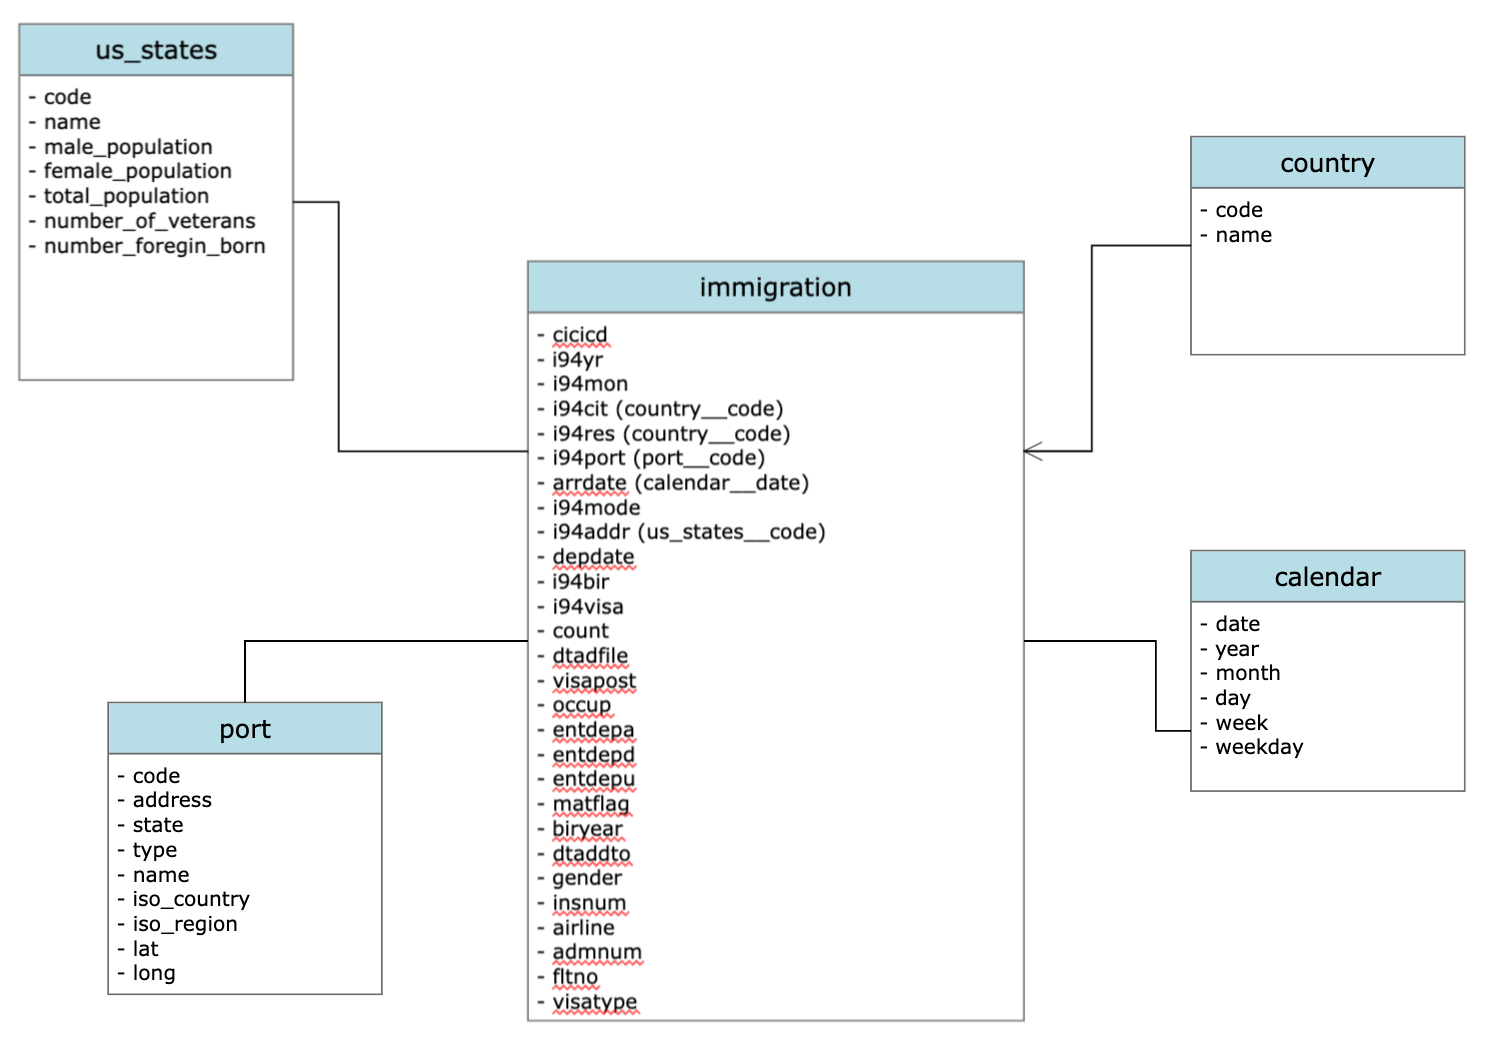



#### 3.2 Mapping Out Data Pipelines
###### *List the steps necessary to pipeline the data into the chosen data model*

1. Create stagging content by cleaning and validating raw content:
- Create ``IMM_STAG_DIR`` based on ``IMM_RAW_DIR``
- Create ``COUNTRIES_STAG_FILE``, ``PORTS_STAG_FILE``, ``MODES_TRANSP_STAG_FILE``, ``STATES_STAG_FILE`` based on ``SAS_LABELS_RAW_FILE`` 
- Create ``AIRPORTS_STAG_FILE`` based on ``AIRPORTS_RAW_FILE``
- Create ``DEMOGRAPHICS_STAG_FILE`` based on ``DEMOGRAPHICS_RAW_FILE``

2. Create model tables from stagging datasets:
- Create **immigration** table: ``IMM_TAB_DIR`` based on ``IMM_STAG_DIR``
- Create **calendar** table: ``CALENDAR_TAB_DIR`` based on ``IMM_STAG_DIR``
- Create **ports** table: ``PORTS_TAB_DIR`` based on ``PORTS_STAG_FILE``, ``AIRPORTS_STAG_FILE`` and ``IMM_STAG_DIR``
- Create **country** table: ``COUNTRY_TAB_DIR`` based on ``COUNTRIES_STAG_FILE``
- Create **us_state** table: ``US_STATES_TAB_DIR`` based on ``STATES_STAG_FILE`` and ``DEMOGRAPHICS_STAG_FILE``



### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [1]:
# etl/stagging.py
def process_immigration_data_file(spark, input_file, output_dir):
    """ Processes a single immigration data file using spark and writes .csv files to ``output_dir`` partitioned by ``year`` and ``month``.

    Parameters:
        spark : Spark session
        input_file (str) : path to input file
        output_dir (str) : path to output directory where .csv files will be written
    """

    df_spark = spark.read.format('com.github.saurfang.sas.spark').load(input_file)

    schema = {
        "cicid": Int(),
        "i94yr": Int(),
        "i94mon": Int(),
        "i94cit": Int (),
        "i94res": Int (),
        "i94port": Str (),
        "arrdate": Int (),
        "i94mode": Int (),
        "i94addr": Str (),
        "depdate": Int(),
        "i94bir": Int (),
        "i94visa": Int (),
        "count": Int (),
        "dtadfile": Int (),
        "visapost": Str (),
        "occup": Str (),
        "entdepa": Str (),
        "entdepu": Str (),
        "matflag": Str (),
        "biryear": Int (),
        "dtaddto": Int (),
        "gender": Str (),
        "insnum": Int (),
        "airline": Str (),
        "admnum": Int (),
        "fltno": Int (),
        "visatype": Str (),
    }

    # enforcing column type
    for col_name, col_type in schema.items():
        df_spark = df_spark.withColumn(col_name, df_spark[col_name].cast(col_type))

    # convert date-type columns to datetime
    get_datetime = udf(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d') if x is not None else x) #  # if x is not None else x)
    df_spark = df_spark\
        .withColumn('arrdate', get_datetime(col('arrdate')))\
        .withColumn('dtaddto', get_datetime(col('dtaddto')))\
        .withColumn('depdate', get_datetime(col('depdate')))\
        .withColumn('dtadfile', get_datetime(col('dtadfile')))

    # drop eventual duplicates
    df_spark.drop_duplicates(['cicid'])

    # write dataframe to csv files partitioned by year and month
    df_spark.write.partitionBy(['i94yr', 'i94mon']).mode('append').format('csv').option('header', 'true').save(output_dir)

def process_immigration_data(spark, input_dir, output_dir):
    """
    Processes immigration dataset (sas files) using spark and writes .csv files to ``output_dir``.

    Parameters:
        spark : spark session
        input_data (str) : path to ``.sas7bdat`` files
        output_dir (str) : path where tables will be written
    """

    # get all files
    files = pathlib.Path(input_dir).rglob('*.sas7bdat') # f'{input_dir}/immigration_data'
    files = [str(f) for f in files]

    for f in files:
        logger.info(f'Processing {f} ...')
        process_immigration_data_file(spark, f, output_dir)

    logger.info('Done processing all immigration SAS files')

In [8]:
# etl/stagging.py
def process_sas_label_descriptions_file(file_path: str, output_countries: str, output_ports: str, output_modes: str, output_states: str):
    """ Parses "I94_SAS_Labels_Descriptions.SAS" and returns 4 dataframes with ("code", "name") as columns
        -  i94cntyl (pd.DataFrame) : "countries" data
        -  i94prtl (pd.DataFrame) : "port" data
        -  i94model (pd.DataFrame) : "mode of transportation" data
        -  i94cntyl (pd.DataFrame) : "USA states" data

    Parameters:
        file_path (str) : path to "I94_SAS_Labels_Descriptions.SAS" file
        output_countries (str) : path where countries df will be written
        output_ports (str) : path where ports df will be written
        output_modes (str) : path where modes of transportation df will be written
        output_states (str) : path where countries df will be written
    """

    with open(file_path, 'r') as f:
        file_content = f.read()

    content_groups = file_content.split('*') # split  by groups based on '*'

    d_groups_str = {
        'i94cntyl': [], # countries
        'i94prtl': [], # ports
        'i94model': [], # modes of transportation
        'i94addrl': [] # USA states
    }

    # capture str data into groups
    for group_str in content_groups:
        for group_name, group_str_list in d_groups_str.items():
            if group_name in group_str:
                group_str_list.append(group_str)
                break

    # validation
    for group_name, group_str_list in d_groups_str.items():
        if len(group_str_list) != 1:
            raise Exception(f'More than one "{group_name}" block was found')

        d_groups_str[group_name] = group_str_list[0]

    # match regex and create dataframe
    df_groups = dict()
    for group_name, content_str in d_groups_str.items():
        data = []
        regex = r"^\s*[\"\']?((\w|\d)+)[\"\']?\s*=\s*(\"|\')?([^\'\"\n]+)(\"|\')?.*$" # match key-pair values
        matches = re.finditer(regex, content_str, re.M)
        for match in matches:
            data.append(
                (match.group(1).strip(), match.group(4).strip())
            )
        df_groups[group_name] = pd.DataFrame(data, columns=['code', 'name'])

    # dataframes
    df_countries = df_groups['i94cntyl']
    df_ports = df_groups['i94prtl']
    df_modes_transport = df_groups['i94model']
    df_states = df_groups['i94addrl']

    # handle duplicates and split columns
    df_countries.drop_duplicates(subset=['code'], keep='last', inplace=True)

    df_ports.drop_duplicates(subset=['code'], keep='last', inplace=True)
    df_ports[['address', 'state']] = df_ports['name'].str.rsplit(',', expand=True, n=1)

    df_modes_transport.drop_duplicates(subset=['code'], keep='last', inplace=True)

    df_states.drop_duplicates(subset=['code'], keep='last', inplace=True)

    # write to output_dir
    pathlib.Path(output_countries).parents[0].mkdir(parents=True, exist_ok=True)
    pathlib.Path(output_ports).parents[0].mkdir(parents=True, exist_ok=True)
    pathlib.Path(output_modes).parents[0].mkdir(parents=True, exist_ok=True)
    pathlib.Path(output_states).parents[0].mkdir(parents=True, exist_ok=True)

    df_countries.to_csv(output_countries, index=False)
    logger.info(f'Done writting countries df to {output_countries}')

    df_ports.to_csv(output_ports, index=False)
    logger.info(f'Done writting ports df to {output_ports}')

    df_modes_transport.to_csv(output_modes, index=False)
    logger.info(f'Done writting modes of transport df to {output_modes}')

    df_states.to_csv(output_states, index=False)
    logger.info(f'Done writting US states df to {output_states}')


In [9]:
# etl/stagging.py

def process_airport_data(file_path: str, output_file: str):
    """Processes airport data and writes data to output_file
    
    Parameters:
        file_path (str) : path to dataset
        output_file (str) : path to output file
    
    """
    df_airports = pd.read_csv(file_path)

    # Clean df_airports
    logger.debug('Dimensions before cleaning: ', df_airports.shape)
    CleanPandasDf.strip_white_text_from_all_cells(df_airports)
    CleanPandasDf.lower_case_all_cells(df_airports)
    CleanPandasDf.drop_all_cols_if_missing_data_is_more_than_perc(df_airports)
    CleanPandasDf.drop_duplicated_rows(df_airports)
    CleanPandasDf.drop_empty_cols(df_airports)
    CleanPandasDf.drop_empty_rows(df_airports)
    df_airports = CleanPandasDf.split_column_based_on_separator(df_airports, 'coordinates', ['lat', 'long'], separator=',', force_types=True, new_cols_types=(float, float))
    logger.debug('Dimensions after cleaning: ', df_airports.shape)

    # write df_airports
    pathlib.Path(output_file).parents[0].mkdir(parents=True, exist_ok=True)
    df_airports.to_csv(output_file, index=False)
    logger.info(f'Done writting airports df to {output_file}')


In [10]:
# etl/stagging.py
def process_demographics_data(spark, file_path: str, output_file: str):

    schema = R([
        Fld("City", Str()),
        Fld("State", Str()),
        Fld("Median Age", Dbl()),
        Fld("Male Population", Int()),
        Fld("Female Population", Int()),
        Fld("Total Population", Int()),
        Fld("Number of Veterans", Int()),
        Fld("Foreign-born", Int()),
        Fld("Average Household Size", Dbl()),
        Fld("State Code", Str()),
        Fld("Race", Str()),
        Fld("Count", Int()),
    ])

    df_city_demographics = spark.read.format('csv').option('header','true').option('delimiter', ';').load(file_path, schema=schema)
    df_city_demographics.drop_duplicates()

        # drop eventual duplicates
    df_city_demographics.drop_duplicates(['State Code'])

    # write dataframe to csv files partitioned by year and month
    df_city_demographics.write.mode('overwrite').format('csv').option('header', 'true').save(output_file)
    logger.info(f'Done writting city demographics df to {output_file}')


In [140]:
# create IMMIGRATION staging data
process_immigration_data(spark, IMM_RAW_DIR, IMM_STAG_DIR)

Processing ../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat ...
Processing ../../data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat ...
Done processing all immigration SAS files


In [11]:
# create stagging data
process_sas_label_descriptions_file(
    file_path=SAS_LABELS_RAW_FILE,
    output_countries=COUNTRIES_STAG_FILE,
    output_ports=PORTS_STAG_FILE,
    output_modes=MODES_TRANSP_STAG_FILE,
    output_states=STATES_STAG_FILE,
    )

Done writting countries df to ./datasets/stagging/df_countries.csv
Done writting ports df to ./datasets/stagging/df_ports.csv
Done writting modes of transport df to ./datasets/stagging/df_modes_transport.csv
Done writting US states df to ./datasets/stagging/df_states.csv


In [12]:
# create airport stagging data
process_airport_data(
    file_path=AIRPORTS_RAW_FILE,
    output_file=AIRPORTS_STAG_FILE)

Droping all cols where number NAN is above 10 % ...
Dropping column "elevation_ft" because it contains 12.7 % NAN values (> 10 %)
Dropping column "continent" because it contains 50.3 % NAN values (> 10 %)
Dropping column "municipality" because it contains 10.3 % NAN values (> 10 %)
Dropping column "gps_code" because it contains 25.5 % NAN values (> 10 %)
Dropping column "iata_code" because it contains 83.3 % NAN values (> 10 %)
Dropping column "local_code" because it contains 47.9 % NAN values (> 10 %)
Droping duplicated rows and keeping last record...
Droping all empty cols ...
Droping all empty rows ...
Done writting airports df to ./datasets/stagging/df_airports.csv


In [17]:
# create demographics stagging data
process_demographics_data(spark, DEMOGRAPHICS_RAW_FILE, DEMOGRAPHICS_STAG_FILE)

Done writting city demographics df to ./datasets/stagging/df_city_demographics.csv


### immigration fact table:
---------

In [46]:
# etl/tables.py
def load_csv_data_with_spark(spark, input_dir):
    """ Loads csv data into memory using spark
    Parameters:
        spark : spark session
        input_dir (str) : directory with csv files or csv file

    Returns:
        Spark dataframe with immigration data
    """
    return spark.read.format('csv').option('header','true').load(input_dir)


def create_immigration_table(df_spark, output_dir):
    """ Creates immigration fact table and dumps it into csv file in ``output_dir``.
    Files are partitioned by ``year`` and ``month``.

    Parameters:
        df_spark : Spark dataframe with data required to create table
        output_dir (str) : directory where csv files will be written
    """
    df_spark=df_spark.drop_duplicates(['cicid'])
    # write immigration table to csv files partitioned by year and month
    df_spark.write.partitionBy(['i94yr', 'i94mon']).mode('overwrite').format('csv').option('header', 'true').save(output_dir)
    logger.info(f'Done writting immigration table in {output_dir}')

In [20]:
# load IMMIGRATION dataset after stagging (used to create >1 table) 
df_immigration = load_csv_data_with_spark(spark, IMM_STAG_DIR)

In [47]:
# create IMMIGRATION table for start model
create_immigration_table(df_immigration, IMM_TAB_DIR)

Done writting immigration table in ./datasets/tables/immigration


### calendar dimension table:
---------

In [21]:
def create_calendar_table(df_spark, output_dir):
    """ Creates calendar table and dumps it into csv file in ``output_dir``.
    Files are partitioned by ``year`` and ``month``.

    Parameters:
        df_spark : Spark dataframe with data required to create table
        output_dir (str) : directory where csv files will be written
    """

    # extract columns to create calendar table
    calendar_table = df_spark.select(
        col('arrdate').alias('date'),
        year('arrdate').alias('year'),
        month('arrdate').alias('month'),
        dayofmonth('arrdate').alias('day'),
        weekofyear('arrdate').alias('week'),
        date_format('arrdate','E').alias('weekday')
    ).drop_duplicates(['date'])

    # write calendar table to csv files partitioned by year and month
    calendar_table.write.partitionBy(['year', 'month']).mode('overwrite').format('csv').option('header', 'true').save(output_dir)
    logger.info(f'Done writting calendar table in {output_dir}')


In [22]:
# create CALENDAR table for start model
create_calendar_table(df_immigration, CALENDAR_TAB_DIR)

Done writting calendar table in ./datasets/tables/calendar


### ports dimension table:
---------

In [23]:
# etl/tables.py
def create_ports_table(spark, df_immigration, ports_file, airports_file, output_dir):
    """ Creates ports dimmension table and dumps it into csv files in ``output_dir``

    Parameters:
        spark : spark session
        df_immigration (Spark dataframe) : immigration dataset
        ports_file (str) : path to ports dataset
        airports_file (str) : path to airports dataset
        output_dir (str) : directory where csv file will be written
    """
    df_ports = spark.read.format('csv').option('header','true').load(ports_file)
    df_airports = spark.read.format('csv').option('header','true').load(airports_file)
    df_airports = df_airports.withColumnRenamed("name","airport_name")

    logger.debug('Number of rows in df_ports: %s', df_ports.count())
    logger.debug('Number of rows in df_airports: %s', df_airports.count())

    # join outer as we are interested on creating ports table (and not airports)
    df = df_ports.join(
        df_airports,
        (df_ports.code == df_airports.ident),
        'outer'
        )

    df = df.join(
        df_immigration,
        (df.code == df_immigration.i94port),
        'outer'
    )

    logger.debug('Number of rows after merging df_ports with df_airports: %s', df.count())
    ports_table = df.select(
        df.code,
        df.address,
        df.state,
        df.type,
        df.name,
        df.iso_country,
        df.iso_region,
        df.lat,
        df.long
        ).drop_duplicates(['code'])

    # write airports table to csv file
    ports_table.write.mode('overwrite').format('csv').option('header','true').save(output_dir)
    logger.info(f'Done writting ports table to {output_dir}')


In [24]:
create_ports_table(
    spark=spark,
    df_immigration=df_immigration,
    ports_file=PORTS_STAG_FILE,
    airports_file=AIRPORTS_STAG_FILE,
    output_dir=PORTS_TAB_DIR
)


Done writting ports table to ./datasets/tables/ports


### country dimension table:
---------

In [25]:
# etl/tables.py
def create_country_table(spark, countries_file, output_dir):
    """ Creates country fact table and dumps it into a csv file in ``output_dir``
    Parameters:
        spark : spark session
        countries_file (str) : path to file with countries dataset
        output_dir (str) : directory where csv files will be written

    Returns:
        Spark dataframe with immigration data
    """
    df_countries = spark.read.format('csv').option('header','true').load(countries_file)

    # write countries table to csv file
    df_countries.write.mode('overwrite').format('csv').option('header','true').save(output_dir)
    logger.info(f'Done writting country table to {output_dir}')


In [26]:
create_country_table(spark, countries_file=COUNTRIES_STAG_FILE, output_dir=COUNTRY_TAB_DIR)

Done writting country table to ./datasets/tables/country


### us states dimension table:
---------

In [27]:
# etl/tables.py
def create_us_state_table(spark, states_file, demographics_file, output_dir):
    """ Creates us_states fact table and dumps it into a csv file in ``output_dir``
    Parameters:
        spark : spark session
        countries_file (str) : path to file with us_states dataset
        output_dir (str) : directory where csv files will be written

    Returns:
        Spark dataframe with immigration data
    """

    df_states = spark.read.format('csv').option('header','true').load(states_file)

    df_city_demographics = spark.read.format('csv').option('header', 'true').load(demographics_file)
    df_states_demographics = df_city_demographics.groupby(df_city_demographics['State Code'], df_city_demographics['State']).agg(
        sp_sum('Male Population').alias('Male Population'),
        sp_sum('Female Population').alias('Female Population'),
        sp_sum('Total Population').alias('Total Population'),
        sp_sum('Number of Veterans').alias('Number of Veterans'),
        sp_sum('Foreign-born').alias('Foreign-born')
        )

    df = df_states.join(
        df_states_demographics,
        (df_states.code == df_states_demographics['State Code']),
        'inner')

    us_states_table = df.select(
        df.code,
        col('State').alias('name'),
        col('Male Population').alias('male_population'),
        col('Female Population').alias('female_population'),
        col('Total Population').alias('total_population'),
        col('Number of Veterans').alias('number_veterans'),
        col('Foreign-born').alias('number_foreign_born'),
        ).drop_duplicates(['code'])

    # write countries table to csv file
    us_states_table.write.mode('overwrite').format('csv').option('header','true').save(output_dir)
    logger.info(f'Created us_states table in {output_dir}')


In [28]:
create_us_state_table(spark, states_file=STATES_STAG_FILE, demographics_file=DEMOGRAPHICS_STAG_FILE, output_dir=US_STATES_TAB_DIR)

Created us_states table in ./datasets/tables/us_states


# Write code here

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [48]:
# Perform quality checks here

# load tables
immigration_table = load_csv_data_with_spark(spark, IMM_TAB_DIR)
calendar_table = load_csv_data_with_spark(spark, CALENDAR_TAB_DIR)
ports_table = load_csv_data_with_spark(spark, PORTS_TAB_DIR)
country_table = load_csv_data_with_spark(spark, COUNTRY_TAB_DIR)
us_states_table = load_csv_data_with_spark(spark, US_STATES_TAB_DIR)


In [56]:
# etl/quality_checks.py
def check_df_has_records(spark_df, table_name):
    """Raises ValueError if ``spark_df`` has no records

    Parameters:
        spark_df : spark dataframe
        table_name (str) : name of the corresponding table
    
    Raises:
        ValueError: if dataframe has no records
    """
    if spark_df.count() == 0:
        raise ValueError(f'Table {table_name} has no records')
    logger.debug(f'Table {table_name} has records.')

def check_col_has_not_repeated_records(spark_df, table_name, col):
    """Checks a given column has no repeated records

    Parameters:
        spark_df : spark dataframe
        table_name (str) : name of the corresponding table
        col (str) : name of the table to be verified
    Raises:
        ValueError: if repeated values are found
    """
    max_count = spark_df.groupby(col).count().agg({"count": "max"}).collect()[0][0]
    if max_count > 1:
        raise ValueError(f'Table {table_name} has repeated values in column {col}')
    logger.debug(f'Column {col} in table {table_name} does not have repeated records.')


In [57]:
tables = {
    'immigration_table': load_csv_data_with_spark(spark, IMM_TAB_DIR),
    'calendar_table': load_csv_data_with_spark(spark, CALENDAR_TAB_DIR),
    'ports_table': load_csv_data_with_spark(spark, PORTS_TAB_DIR),
    'country_table': load_csv_data_with_spark(spark, COUNTRY_TAB_DIR),
    'us_states_table': load_csv_data_with_spark(spark, US_STATES_TAB_DIR)
}
tables_pks = {
    'immigration_table': 'cicid',
    'calendar_table': 'date',
    'ports_table': 'code',
    'country_table': 'code',
    'us_states_table': 'code',
}

for table_name in tables.keys():
    df = tables[table_name]
    pk = tables_pks[table_name]
    check_df_has_records(df, table_name) # validate table is not empty
    check_col_has_not_repeated_records(df, table_name, pk) # validate all pk records are unique

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

##### immigration table

In [11]:
immigration_table_desc = pd.DataFrame({
    'Attribute': [
        'cicid',
        'i94yr',
        'i94mon',
        'i94cit',
        'i94res',
        'i94port',
        'arrdate',
        'i94mode',
        'i94addr',
        'depdate',
        'i94bir',
        'i94visa',
        'count',
        'dtadfile',
        'visapost',
        'occup',
        'entdepa',
        'entdepd',
        'entdepu',
        'matflag',
        'biryear',
        'dtaddto',
        'gender',
        'insnum',
        'airline',
        'admnum',
        'fltno',
        'visatype',
    ],
    'Description': [
        'Unique record ID',
        '4 digit year',
        'Numeric month',
        '3 digit code for immigrant country of birth',
        '3 digit code for immigrant country of residence',
        'Port of admission',
        'Arrival Date in the USA',
        'Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)',
        'USA State of arrival',
        'Departure Date from the USA',
        'Age of Respondent in Years',
        'Visa codes collapsed into three categories',
        'Field used for summary statistics',
        'Character Date Field - Date added to I-94 Files',
        'Department of State where where Visa was issued',
        'Occupation that will be performed in U.S',
        'Arrival Flag - admitted or paroled into the U.S.',
        'Departure Flag - Departed, lost I-94 or is deceased',
        'Update Flag - Either apprehended, overstayed, adjusted to perm residence',
        'Match flag - Match of arrival and departure records',
        '4 digit year of birth',
        'Character Date Field - Date to which admitted to U.S. (allowed to stay until)',
        'Non-immigrant sex',
        'INS number',
        'Airline used to arrive in U.S.',
        'Admission Number',
        'Flight number of Airline used to arrive in U.S.',
        'Class of admission legally admitting the non-immigrant to temporarily stay in U.S.',
    ]
})
immigration_table_desc['Original Dataset'] = ['immigration dataset'] * len(immigration_table_desc)
print('Immigration table:\n')
immigration_table_desc

Immigration table:



,Attribute,Description,Original Dataset
0,cicid,Unique record ID,immigration dataset
1,i94yr,4 digit year,immigration dataset
2,i94mon,Numeric month,immigration dataset
3,i94cit,3 digit code for immigrant country of birth,immigration dataset
4,i94res,3 digit code for immigrant country of residence,immigration dataset
5,i94port,Port of admission,immigration dataset
6,arrdate,Arrival Date in the USA,immigration dataset
7,i94mode,Mode of transportation (1 = Air; 2 = Sea; 3 = ...,immigration dataset
8,i94addr,USA State of arrival,immigration dataset
9,depdate,Departure Date from the USA,immigration dataset


##### calendar table

In [13]:
calendar_table_desc = pd.DataFrame({
    'Attribute': [
        'date',
        'year',
        'month',
        'day',
        'week',
        'weekday',    
    ],
    'Description': [
        'arrival date in the US',
        'corresponding year',
        'corresponding month',
        'corresponding day',
        'corresponding week',
        'corresponding weekday',
    ]
})
calendar_table_desc['Original Dataset'] = ['immigration dataset'] * len(calendar_table_desc)
print('calendar table:\n')
calendar_table_desc

calendar table:



,Attribute,Description,Original Dataset
0,date,arrival date in the US,immigration dataset
1,year,corresponding year,immigration dataset
2,month,corresponding month,immigration dataset
3,day,corresponding day,immigration dataset
4,week,corresponding week,immigration dataset
5,weekday,corresponding weekday,immigration dataset


##### ports table

In [14]:
ports_table_desc = pd.DataFrame({
    'Attribute': [
        'code',
        'address',
        'state',
        'type',
        'name',
        'iso_country',    
        'iso_region',    
        'lat',    
        'long',    
    ],
    'Description': [
        'Port code',
        'port address',
        'coressponding state',
        'type of port',
        'name',
        'country code in ISO format',    
        'region code in ISO format',    
        'latitude coordinate',    
        'longitude coordinate',  
    ],
    'Original Dataset': [
        'Immigration SAS labels',
        'Immigration SAS labels',
        'airports dataset',
        'airports dataset',
        'airports dataset',
        'airports dataset',    
        'airports dataset',    
        'airports dataset',    
        'airports dataset',  
    ]
})
print('ports table:\n')
ports_table_desc

ports table:



,Attribute,Description,Original Dataset
0,code,Port code,Immigration SAS labels
1,address,port address,Immigration SAS labels
2,state,coressponding state,airports dataset
3,type,type of port,airports dataset
4,name,name,airports dataset
5,iso_country,country code in ISO format,airports dataset
6,iso_region,region code in ISO format,airports dataset
7,lat,latitude coordinate,airports dataset
8,long,longitude coordinate,airports dataset


##### country table

In [16]:
country_table_desc = pd.DataFrame({
    'Attribute': [
        'code',
        'name',
    ],
    'Description': [
        'country code',
        'country name',
    ],
    'Original Dataset': [
        'Immigration SAS labels',
        'Immigration SAS labels',
    ]
})
print('country table:\n')
country_table_desc

country table:



,Attribute,Description,Original Dataset
0,code,country code,Immigration SAS labels
1,name,country name,Immigration SAS labels


##### us_states table

In [17]:
us_sates_desc = pd.DataFrame({
    'Attribute': [
        'code',
        'name',
        'male_population',
        'female_population',
        'total_population',
        'number_of_veterans',    
        'number_of_foregin_born',    
    ],
    'Description': [
        'US state code',
        'US state name',
        'male population in the state',
        'female population in the state',
        'total population in the state',
        'number veternans in the state',    
        'number of foregin born in the state',     
    ],
    'Original Dataset': [
        'Immigration SAS labels',
        'Immigration SAS labels',
        'demographics dataset',
        'demographics dataset',
        'demographics dataset',
        'demographics dataset',
        'demographics dataset',
    ]
})
print('us_states table:\n')
us_sates_desc

us_states table:



,Attribute,Description,Original Dataset
0,code,US state code,Immigration SAS labels
1,name,US state name,Immigration SAS labels
2,male_population,male population in the state,demographics dataset
3,female_population,female population in the state,demographics dataset
4,total_population,total population in the state,demographics dataset
5,number_of_veterans,number veternans in the state,demographics dataset
6,number_of_foregin_born,number of foregin born in the state,demographics dataset


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

##### Choice of technologies for this project:
- Spark and pandas for data wrangling: spark and pandas are very flexible. Spark scales very well if data size is increased (we could run Spark on an Hadoop system or use an AWS EMR cluster), while pandas is only used in dimension datasets (smaller vs fact dataset).
- DM tables are stored on csv files on AWS S3 (data lake). This is enough for this exercise and a cheaper solution than AWS Redshift. Data can be accessed through AWS Athena, with AWS Glue crawlers, for instance.

##### How often data should be updated and why
- Data should be updated at least once per month, as some of the tables are partitioned by month.

##### If data is increased by 100x
- First, instead of storing the tables into csv files, we could store them into parquet files, which are better optimized for storage (columnar storege, which is more efficient when using bigger datasets).
- Secondly, we could store the data into AWS S3
- Thirdly, we could use a Spark cluster to load all the data into memory and use it for processing. A convenient option would be to use AWS EMR Spark cluster.
- Finally, AWS Redshift might also be considered.

##### Data populates a dashboard that must be updated on a daility basis by 7am every day
- An Airflow DAG could be created with the full pipeline steps and selected to be triggered on a daily basis.

##### The database needed to be accessed by 100+ people
- Instead of storing all the tables in S3 (data lake), another option would be to store it in a AWS Redshift cluster. AWS Redshift offers massive parallel processing (MPP) and columnar storage, which both are more efficient for queries. - Furthermore, the DM schema might be slightly changed. For instance, we could use auto-increment primary keys, which are faster for queries than using strings. Furthermore, when creating the tables, a distribution style might be considered.